<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 8: OpenStreetMap and OSMnx</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* OSMnx examples: https://github.com/gboeing/osmnx-examples
* pyrosm examples: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

# OSMnx overview: querying, simplifying, visualizing, saving

In [7]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd

%matplotlib inline
ox.__version__

'1.2.0'

You can configure OSMnx using `ox.config()`. See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.config) for the settings you can configure. For example, by default OSMnx caches all server responses to prevent repeatedly hitting the server for the same query every time you run it. This both makes our code faster on subsequent runs and helps us be a "good neighbor" to the server. But you can turn caching off (or back on again) with the `use_cache` parameter. Any parameters not passed to the config function are (re-)set to their original default values whenever you call it.

In [8]:
# turn response caching off
ox.config(use_cache=False)

# turn it back on and turn on/off logging to your console
ox.config(use_cache=True, log_console=False)

/home/manuelbanza/Environments/spatial_ds/lib/python3.8/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Part 1: get place boundaries from OpenStreetMap

OSMnx lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

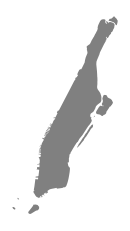

In [9]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

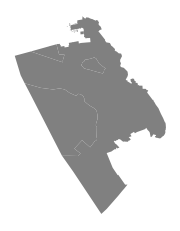

In [10]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("files/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [11]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocode_to_gdf(["N240109189", "W427818536"], by_osmid=True)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,POINT (13.38886 52.51704),52.677036,52.357036,13.548860,13.228860,385898,node,240109189,52.517037,13.388860,"Berlin, 10117, Germany",place,city,0.787539
1,"POLYGON ((-73.98141 40.76846, -73.98135 40.768...",40.800314,40.764745,-73.949606,-73.981408,197841963,way,427818536,40.782773,-73.965363,"Central Park, New York County, New York, Unite...",leisure,park,0.565172


## Part 2: download and model street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, GeoPackages, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

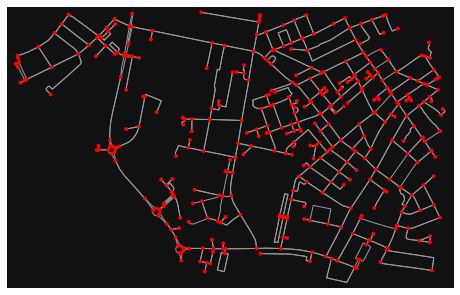

In [12]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43
# define a bounding box around ITU
north, south, east, west = 55.6646, 55.6540, 12.5767, 12.6077

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
ox.plot_graph(G, node_color="r");

#### Method #2, pass a lat-lng point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

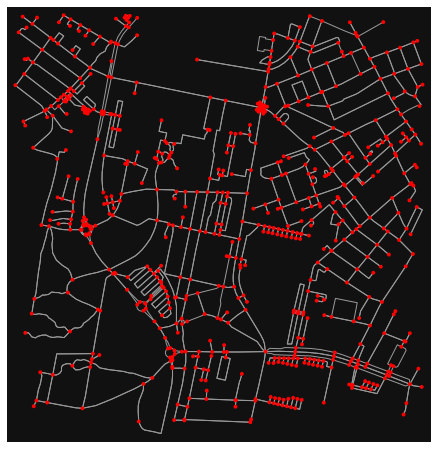

In [13]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)
# define a point at ITU
location_point = (55.659323, 12.591472)

# create bikeable network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="bike")
ox.plot_graph(G, node_color="r");

#### Method #3, pass a lat-lng point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.

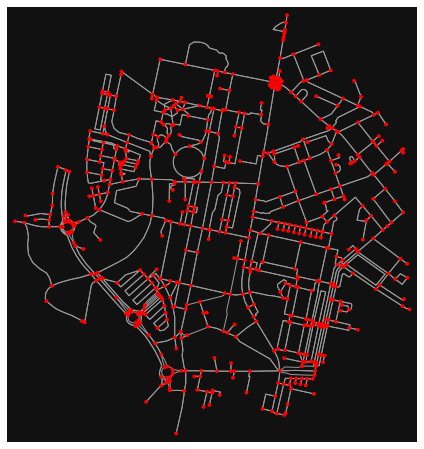

In [14]:
# same point again, but create network only of nodes within 750m along the network from point
G1 = ox.graph_from_point(location_point, dist=750, dist_type="network")
ox.plot_graph(G1, node_color="r");

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

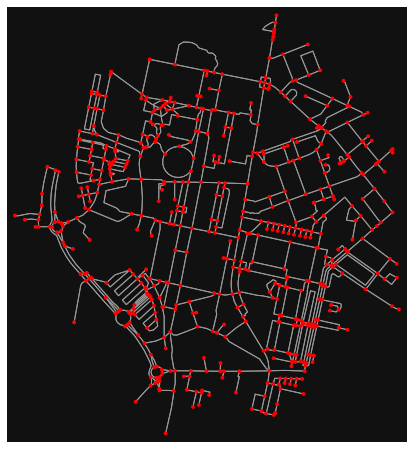

In [15]:
# create network only of nodes within 750m walking along the network from point
G2 = ox.graph_from_point(location_point, dist=750, dist_type="network", network_type="walk")
ox.plot_graph(G2, node_color="r");

#### Method #4, pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

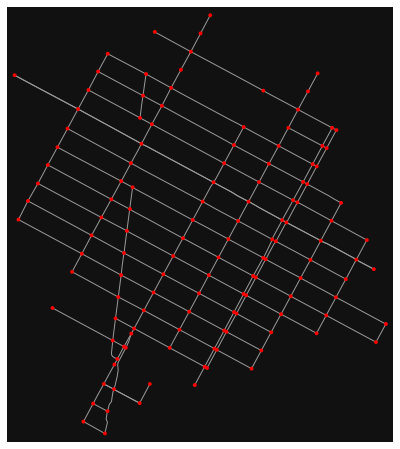

In [16]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected, node_color="r");

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

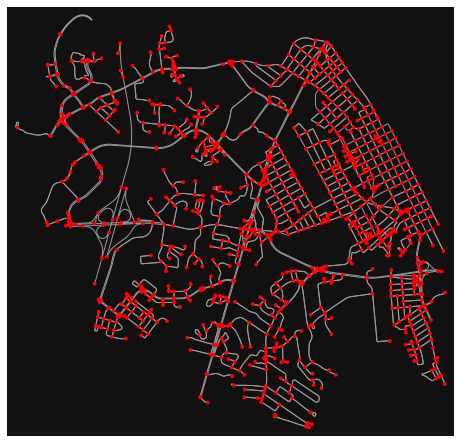

In [17]:
G = ox.graph_from_place("Frederiksberg", network_type="drive")
ox.plot_graph(G, node_color="r");

This is not the Frederiksberg we were looking for! It is Fredericksburg in Virginia. What happened? Names are resolved via nominatim, which returns the first result that is a polygon or multipolygon. All results are listed here: https://nominatim.openstreetmap.org/ui/search.html?q=Frederiksberg

To fetch a different result, use the parameter `which_result`:

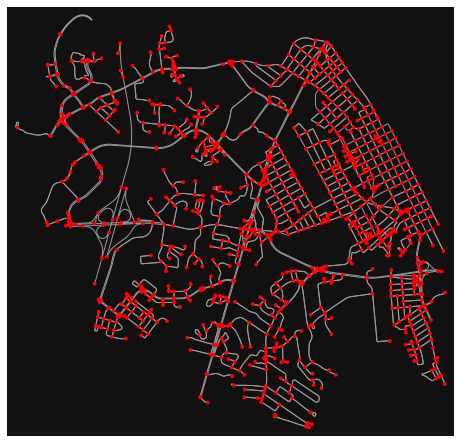

In [18]:
# Frederiksberg, Sorø Municipality, Denmark
G = ox.graph_from_place("Frederiksberg", network_type="drive")
ox.plot_graph(G, node_color="r");

But where is the Frederiksberg we are looking for??

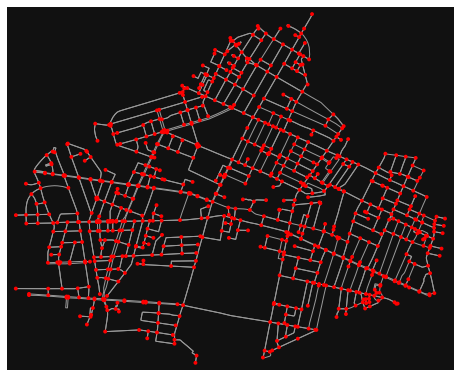

In [19]:
# Frederiksberg Municipality, Denmark
G_fred = ox.graph_from_place("Frederiksberg Municipality", network_type="drive")
G_fred = ox.project_graph(G_fred)
ox.plot_graph(G_fred, node_color="r");

In [20]:
G_fred

Be aware that this is a MultiDiGraph, i.e. a multigraph (parallel edges are possible) that is directed. Because there can be multiple links between a pair of nodes, each link is identified with a triple: (node1id, node2id, counter)

In [21]:
list(G_fred.edges)[:10]

[(576734, 576735, 0),
 (576734, 281882807, 0),
 (576734, 282822735, 0),
 (576734, 929287662, 0),
 (576735, 576734, 0),
 (576735, 2955858500, 0),
 (576735, 282823010, 0),
 (281882807, 576734, 0),
 (281882807, 281882851, 0),
 (281882807, 792862, 0)]

Beware of weird or unexpected administrative regions, so always double-check your results:

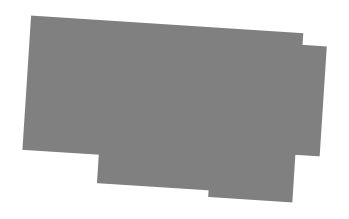

In [22]:
# get the boundary polygon for Copenhagen, project it, and plot it
city = ox.geocode_to_gdf("Copenhagen municipality")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

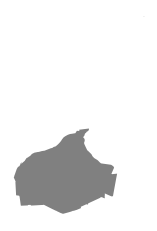

In [23]:
# get the boundary polygon for Copenhagen including Frederiksberg, project it, and plot it
city = ox.geocode_to_gdf(["Copenhagen municipality", "Frederiksberg municipality"])
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

If you look closely you can see a thin boundary around Frederiksberg. So, this just plotted both regions, but if you wanted to use the shapes further, for example as a boundary to select further objects, you could dissolve the polygons with shapely:

In [24]:
city_proj

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((347491.393 6179687.774, 347497.682 6...",55.738951,55.738820,12.571172,12.570778,154244091,way,216661174,55.738895,12.570975,"Embassy of Hungary, Copenhagen, Øregårdsvænget...",office,diplomatic,0.21100
1,"POLYGON ((342263.138 6173216.083, 342337.861 6...",55.697681,55.666502,12.557342,12.491315,284172839,relation,2186660,55.681939,12.523431,"Frederiksberg Municipality, Capital Region of ...",boundary,administrative,0.67753


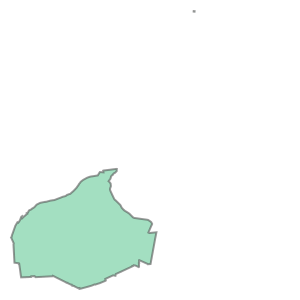

In [25]:
from shapely.ops import unary_union
unary_union([p for p in city_proj.geometry])

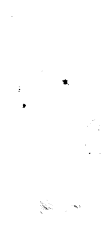

In [26]:
# get the boundary polygon for France, project it, and plot it
france = ox.geocode_to_gdf("France")
france = ox.project_gdf(france)
ax = france.plot(fc="k", ec="none")
ax.axis("off");

/home/manuelbanza/Environments/spatial_ds/lib/python3.8/site-packages/osmnx/graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


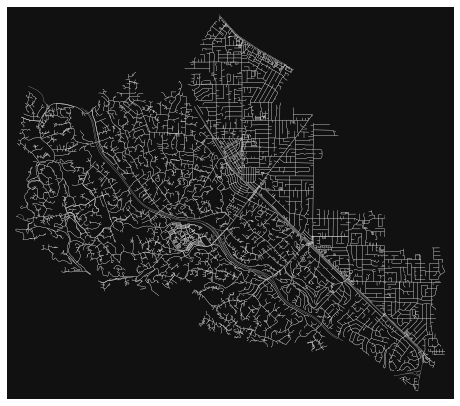

In [27]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, clean_periphery=False)

# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2);

#### Method #6, pass a polygon ####

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a shapefile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

In [28]:
calif = gpd.read_file("files/ZillowNeighborhoods-CA")
calif

,STATE,COUNTY,CITY,NAME,REGIONID,geometry
0,CA,Alameda,Fremont,28 Palms,272706.0,"POLYGON ((-121.98757 37.52286, -121.98773 37.5..."
1,CA,Alameda,Fremont,Ardenwood,268001.0,"POLYGON ((-122.04133 37.56604, -122.04069 37.5..."
2,CA,Alameda,Fremont,Baylands,268017.0,"POLYGON ((-121.94596 37.49091, -121.93807 37.4..."
3,CA,Alameda,Fremont,Blacow,268026.0,"POLYGON ((-121.97197 37.52264, -121.97077 37.5..."
4,CA,Alameda,Fremont,Brookvale,268034.0,"MULTIPOLYGON (((-122.00390 37.58150, -121.9969..."
...,...,...,...,...,...,...
943,CA,Yolo,Davis,Wildhorse Gc,268595.0,"POLYGON ((-121.71346 38.56853, -121.71343 38.5..."
944,CA,Yolo,Davis,Willowbank,268598.0,"POLYGON ((-121.69846 38.54302, -121.69627 38.5..."
945,CA,Yolo,Davis,Willowcreek,268599.0,"POLYGON ((-121.70240 38.54599, -121.70245 38.5..."
946,CA,Yolo,Davis,Woodbridge,276117.0,"POLYGON ((-121.70240 38.54599, -121.69837 38.5..."


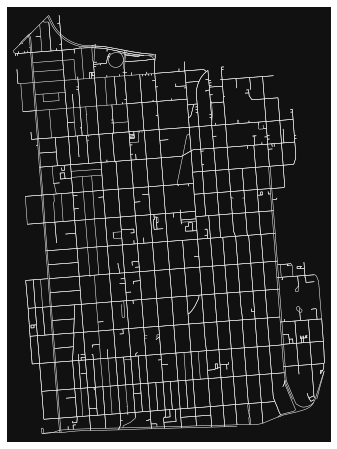

In [29]:
mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = mission_district["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")
ox.plot_graph(G2, node_size=0, edge_color="w", edge_linewidth=0.5);

#### Method #7, load a .osm xml file

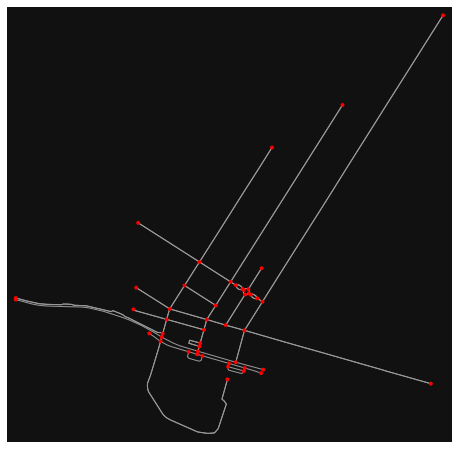

In [30]:
# create graph from .osm extract file
G = ox.graph_from_xml("files/West-Oakland.osm.bz2")
ox.plot_graph(G, node_color="r");

## Part 3: simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs).

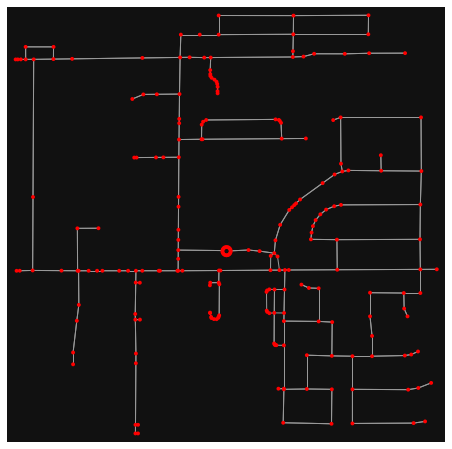

In [31]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)
ox.plot_graph(G, node_color="r");

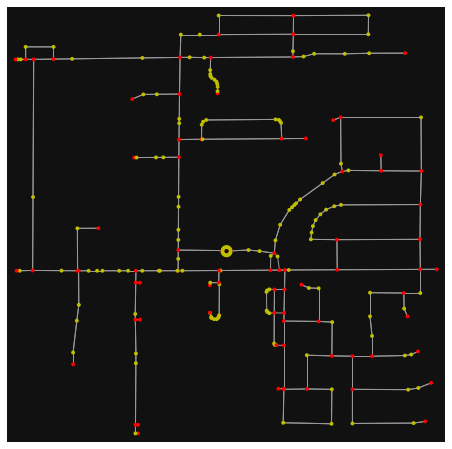

In [32]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc);

The dots above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

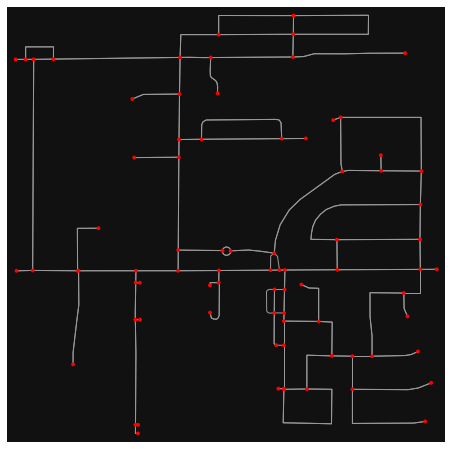

In [33]:
# simplify the network
G = ox.simplify_graph(G)
ox.plot_graph(G, node_color="r");

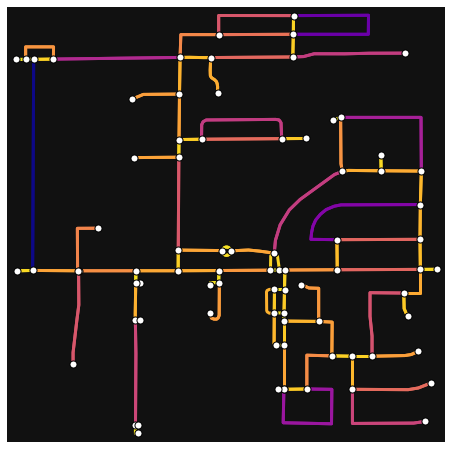

In [34]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [35]:
ec

41542771    41542772    0     (0.990439, 0.796859, 0.14787, 1.0)
                        1    (0.605485, 0.085854, 0.622686, 1.0)
            7655352447  0    (0.940015, 0.975158, 0.131326, 1.0)
41542772    41542771    0     (0.990439, 0.796859, 0.14787, 1.0)
                        1    (0.605485, 0.085854, 0.622686, 1.0)
                                            ...                 
7738027130  41672314    0    (0.940015, 0.975158, 0.131326, 1.0)
            41672313    0    (0.986345, 0.640969, 0.217948, 1.0)
            7738027128  0    (0.949217, 0.517763, 0.295662, 1.0)
9527190857  41672318    0      (0.964021, 0.90795, 0.14937, 1.0)
            4850315875  0    (0.976428, 0.596595, 0.244767, 1.0)
Length: 190, dtype: object

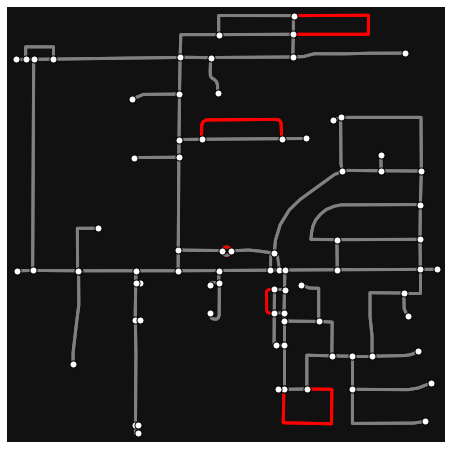

In [36]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

We can see the parallel edges in the data:

In [37]:
list(G.edges)[:10]

[(41542771, 41542772, 0),
 (41542771, 41542772, 1),
 (41542771, 7655352447, 0),
 (41542772, 41542771, 0),
 (41542772, 41542771, 1),
 (41542772, 42238826, 0),
 (41542778, 41612013, 0),
 (41542778, 371845086, 0),
 (41542778, 42449935, 0),
 (41544344, 41756544, 0)]

### Highlighting map properties in Frederiksberg

In [38]:
G_fred.edges[576734, 576735, 0]

{'osmid': [113540480, 1700501],
 'name': 'Nordre Fasanvej',
 'highway': 'tertiary',
 'maxspeed': '50',
 'oneway': False,
 'reversed': False,
 'length': 154.328,
 'geometry': <shapely.geometry.linestring.LineString at 0x7f598a1981c0>}

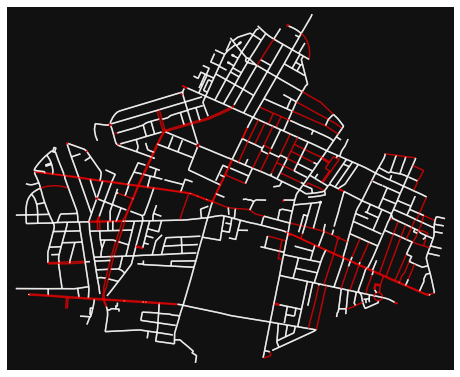

In [39]:
# highlight all one-way edges in the Frederiksberg network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G_fred.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_fred, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

Be aware that streets made up of two (minimally separated) lanes could have their lanes marked as "oneway", but effectively the street is twoway! For example, Roskildevej on the bottom left of the map:

<img src="files/roskildevej.jpg">

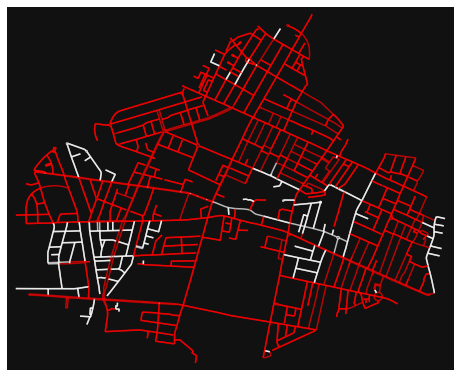

In [40]:
# highlight all speed limit 50 edges in the Frederiksberg network from earlier
ec = ["r" if "maxspeed" in data and data["maxspeed"] == "50" else "w" for u, v, key, data in G_fred.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_fred, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

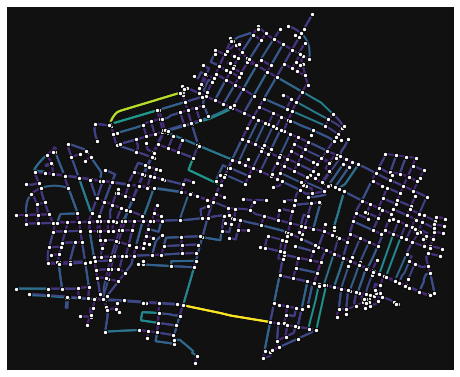

In [41]:
# Show edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G_fred, attr="length", cmap="viridis")
fig, ax = ox.plot_graph(
    G_fred, node_color="w", node_edgecolor="k", node_size=20, edge_color=ec, edge_linewidth=2
)

## Part 4: saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](05-save-load-networks.ipynb).

In [42]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G_fred, filepath="network.gpkg")

In [43]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G_fred, filepath="network.graphml")

# Routing, speed imputation, and travel times

Including parallelized shortest-path solving via built-in multiprocessing in OSMnx.

## 1. Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

In [44]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(G_fred), n=30)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

(points, X, Y, X0, Y0)

(u           v           key
 7235745     7235744     0      POINT (345816.375 6173444.868)
 7786961     7786971     0      POINT (345250.018 6173542.459)
 11056223    1875640852  0      POINT (343238.743 6172410.993)
 726570      8209948     0      POINT (345124.796 6173606.524)
 319307873   995454219   0      POINT (343622.526 6173649.288)
 8078441     8078437     0      POINT (342514.398 6173484.507)
 20908395    20908397    0      POINT (343139.806 6172558.451)
 297822739   278526539   0      POINT (342564.095 6173615.298)
 7489468384  833442021   0      POINT (344931.888 6173020.767)
 20908225    20908219    0      POINT (343596.280 6173080.603)
 791971      793087      0      POINT (345257.250 6172548.361)
 20974557    304136616   0      POINT (344414.464 6172261.708)
 781567      814327      0      POINT (345907.040 6173320.118)
 20908391    1282576356  0      POINT (343064.967 6173008.563)
 17852720    20908434    0      POINT (343963.754 6174186.039)
 20908406    20974555    0

In [45]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(G_fred, X, Y, return_dist=True)
(nodes[:4],dists[:4])

([7235744, 7786971, 11056223, 8209948],
 [12.532972290174778, 50.6773110469267, 43.03910197742877, 6.350872818044662])

In [46]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(G_fred, X0, Y0)
node

282822564

In [47]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(G_fred, X, Y, return_dist=True)
(edges[:4],dists[:4])

([(7235744, 7235745, 0),
  (7786971, 7786961, 0),
  (11056223, 1875640852, 0),
  (8209948, 726570, 0)],
 [8.80099642047026e-11,
  1.8747872046986643e-11,
  7.458297770993665e-11,
  8.549520230908917e-11])

In [48]:
# find the nearest edge to a single point
edge = ox.nearest_edges(G_fred, X0, Y0)
edge

(282822564, 576735, 0)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

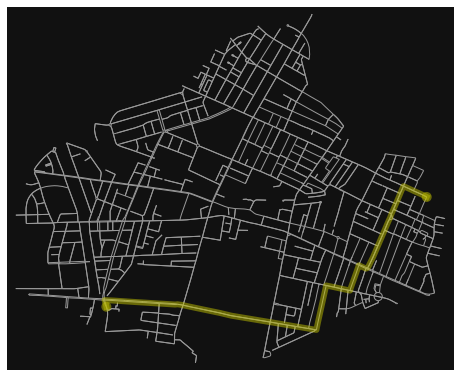

In [49]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_fred)[41]
dest = list(G_fred)[220]
route = ox.shortest_path(G_fred, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G_fred, route, route_color="y", route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:

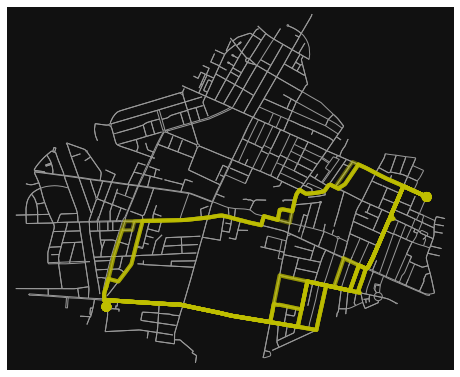

In [50]:
routes = ox.k_shortest_paths(G_fred, orig, dest, k=20, weight="length")
fig, ax = ox.plot_graph_routes(G_fred, list(routes), route_colors="y", route_linewidth=4, node_size=0)

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [51]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G_fred)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [52]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",81.5,50.0,5.9
living_street,106.6,50.0,7.7
residential,100.8,47.3,7.7
tertiary,88.2,49.4,6.4
tertiary_link,8.0,45.0,0.7
unclassified,41.3,50.0,3.0


In [53]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 30, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [54]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

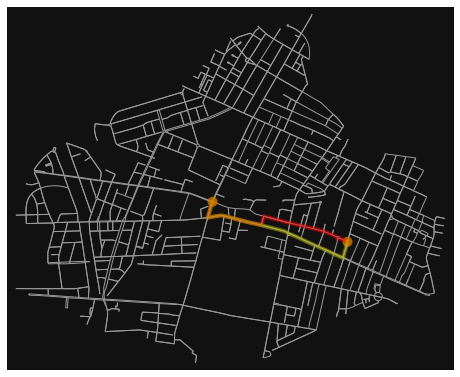

In [55]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [56]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 1576 meters and takes 128 seconds.
Route 2 is 1642 meters and takes 120 seconds.


The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/12-node-elevations-edge-grades.ipynb).

## 4. Multiprocessing

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing, see: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed-time.ipynb.

I suggest to use igraph as a much faster alternative: https://igraph.org/python/

# Simplify network topology and consolidate intersections

Complex intersection consolidation

Many real-world street networks feature complex intersections and traffic circles, resulting in a cluster of graph nodes where there is really just one true intersection, as we would think of it in transportation or urban design. Similarly, divided roads are often represented by separate centerline edges: the intersection of two divided roads thus creates 4 nodes, representing where each edge intersects a perpendicular edge, but these 4 nodes represent a single intersection in the real world. Traffic circles similarly create a cluster of nodes where each street's edge intersects the roundabout.

OSMnx can consolidate nearby intersections and optionally rebuild the graph's topology.

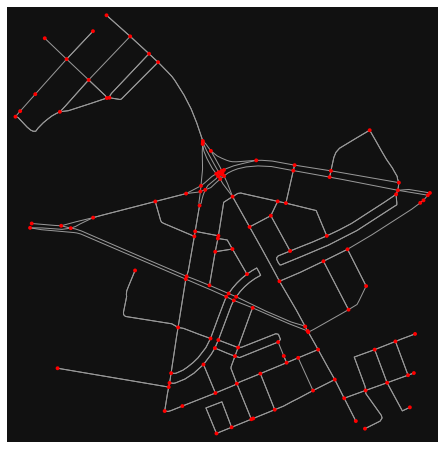

In [57]:
# get a street network and plot it with all edge intersections
point = 55.667708, 12.596266
G = ox.graph_from_point(point, network_type="drive", dist=500)
ox.plot_graph(G, node_color="r");

Notice the complex intersections creating clusters of nodes.

We'll specify that any nodes with 15 meter buffers of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of consolidated intersections.

In [58]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=15, dead_ends=False
)
len(intersections)

72

In [59]:
# compare to number of nodes in original graph
len(G)

122

Note that these cleaned up intersections give us more accurate intersection counts and densities, but do not alter or integrate with the network's topology.

To do that, we need to **rebuild the graph**.

In [60]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G2)

75

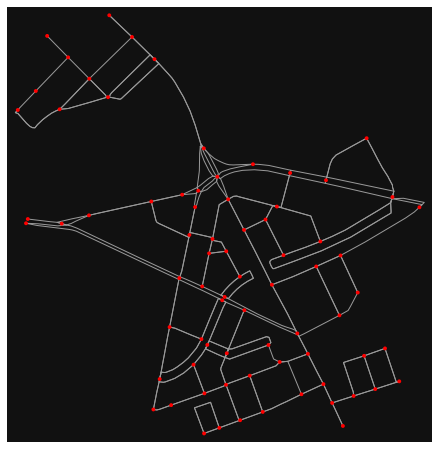

In [61]:
fig, ax = ox.plot_graph(G2, node_color="r")

Notice how the traffic circles' many nodes are merged into a new single centroid node, with edge geometries extended to connect to it. Similar consolidation occurs at the intersection of the divided roads.

Running `consolidate_intersections` with `rebuild_graph=True` may yield somewhat (but not very) different intersection counts/densities compared to `rebuild_graph=False`. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them.

This prevents topologically remote but spatially proximate nodes from being merged. For example:

  - A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connnect their edges: they are distinct junctions in the system of roads.
  - In a residential neighborhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using `rebuild_graph=True` because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than `rebuild_graph=False`.

## Cleaning up the periphery of the network

This is related to simplification. OSMnx by default (with clean_periphery parameter equal to True) buffers the area you request by 0.5km, and then retrieves the street network within this larger, buffered area. Then it simplifies the topology so that nodes represent intersections of streets (rather than including all the interstitial OSM nodes). Then it calculates the (undirected) degree of each node in this larger network. Next it truncates this network by the actual area you requested (either by bounding box, or by polygon). Finally it saves a dictionary of node degree values as a graph attribute.

This has two primary benefits. First, it cleans up stray false edges around the periphery. If clean_periphery=False, peripheral non-intersection nodes within the requested area appear to be cul-de-sacs, as the rest of the edge leading to an intersection outside the area is ignored. If clean_periphery=True, the larger graph is first created, allowing simplification of such edges to their true intersections, allowing their entirety to be pruned after truncating down to the actual requested area. Second, it gives accurate node degrees by both a) counting node neighbors even if they fall outside the retained network (so you don't claim a degree-4 node is degree-2 because only 2 of its neighbors lie within the area), and b) not counting all those stray false edges' terminus nodes as cul-de-sacs that otherwise grossly inflate the count of nodes with degree=1, even though these nodes are really just interstitial nodes in the middle of a chopped-off street segment between intersections.

See two examples below.

In [62]:
# get some bbox
bbox = ox.utils_geo.bbox_from_point((45.518698, -122.679964), dist=300)
north, south, east, west = bbox

/home/manuelbanza/Environments/spatial_ds/lib/python3.8/site-packages/osmnx/graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


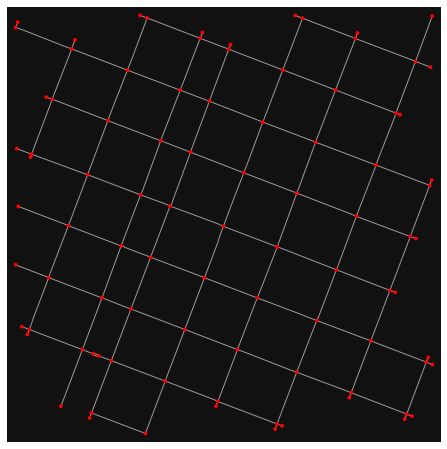

In [63]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive", clean_periphery=False)
ox.plot_graph(G, node_color="r");

In [64]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G.degree())
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 30, 2: 2, 3: 6, 4: 52}

Above, notice all the peripheral stray edge stubs. Below, notice these are cleaned up and that the node degrees are accurate with regards to the wider street network that may extend beyond the limits of the requested area.

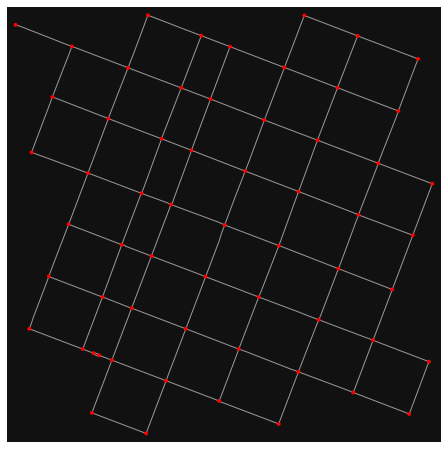

In [65]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
ox.plot_graph(G, node_color="r");

In [66]:
# the streets per node distribution for this cleaned up graph is more accurate
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)
# dict vals = number of nodes with that count
k = nx.get_node_attributes(G, "street_count")
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 0, 2: 0, 3: 3, 4: 57}

# Custom filters and other infrastructure types

Use custom filters to fine-tune your network. OSMnx uses `network_type` presets to query for streets that allow walking, biking, driving, etc. You can override this by passing a `custom_filter` to specify specific OSM ways you want in your graph.

34 motorway


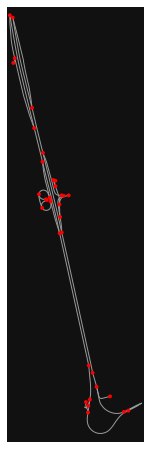

11 primary


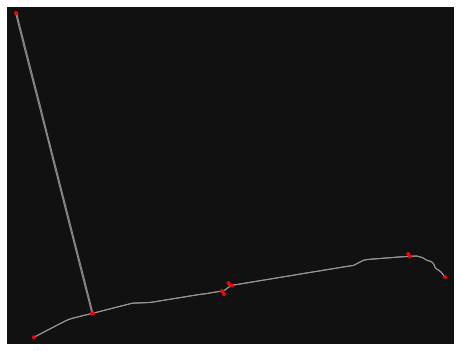

45 motorway + primary


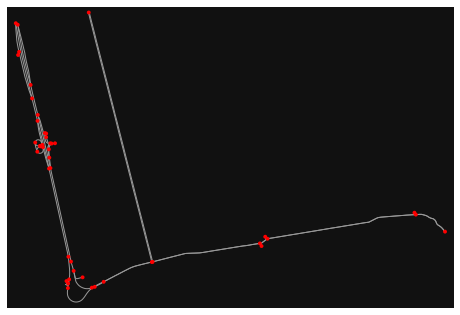

In [67]:
place = {"city": "Berkeley", "state": "California"}

# only get motorway ways
cf = '["highway"~"motorway"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway")
ox.plot_graph(G, node_color="r");

# only get primary ways
cf = '["highway"~"primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "primary")
ox.plot_graph(G, node_color="r");

# use the pipe (|) as 'or' operator
cf = '["highway"~"motorway|primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway + primary")
ox.plot_graph(G, node_color="r");

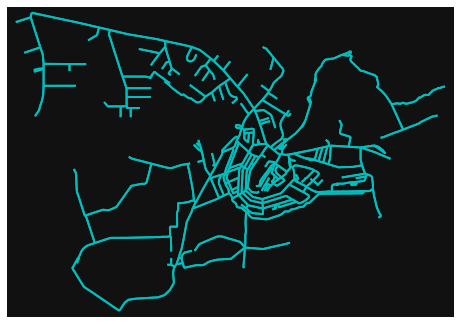

In [68]:
# network of the canals of amsterdam
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')
ox.plot_graph(G, edge_color="c", edge_linewidth=2, node_size=0);

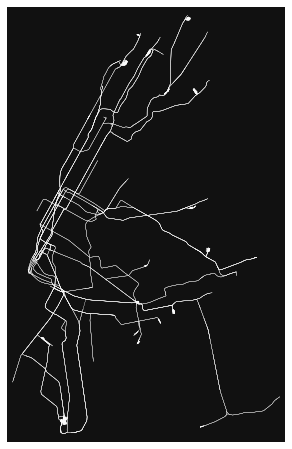

In [69]:
# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
ox.settings.useful_tags_way += ["railway"]
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2);

To download the road network for an entire country, you often need to limit your query to something like motorways only, to fit in your computer's RAM. For large queries, such as the entire nation of Belgium, OSMnx will subdivide your query into multiple server requests to download all the data, then assemble the graph.

In [70]:
# %%time
# # get only motorways, trunks, and their links in all of Belgium
# # takes a couple minutes to do all the downloading and processing
# # OSMnx automatically divides up the query into multiple requests to not overload server
# cf = '["highway"~"motorway|motorway_link|trunk|trunk_link"]'
# G = ox.graph_from_place("Belgium", network_type="drive", custom_filter=cf)
# ox.plot_graph(G, node_size=0);

Commented out because kernel dies in docker.

# pyrosm

Use pyrosm instead for large data sets or for more flxibility with custom filters: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

In [71]:
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("helsinki_pbf")
# Initialize the OSM parser object
osm = OSM(fp)

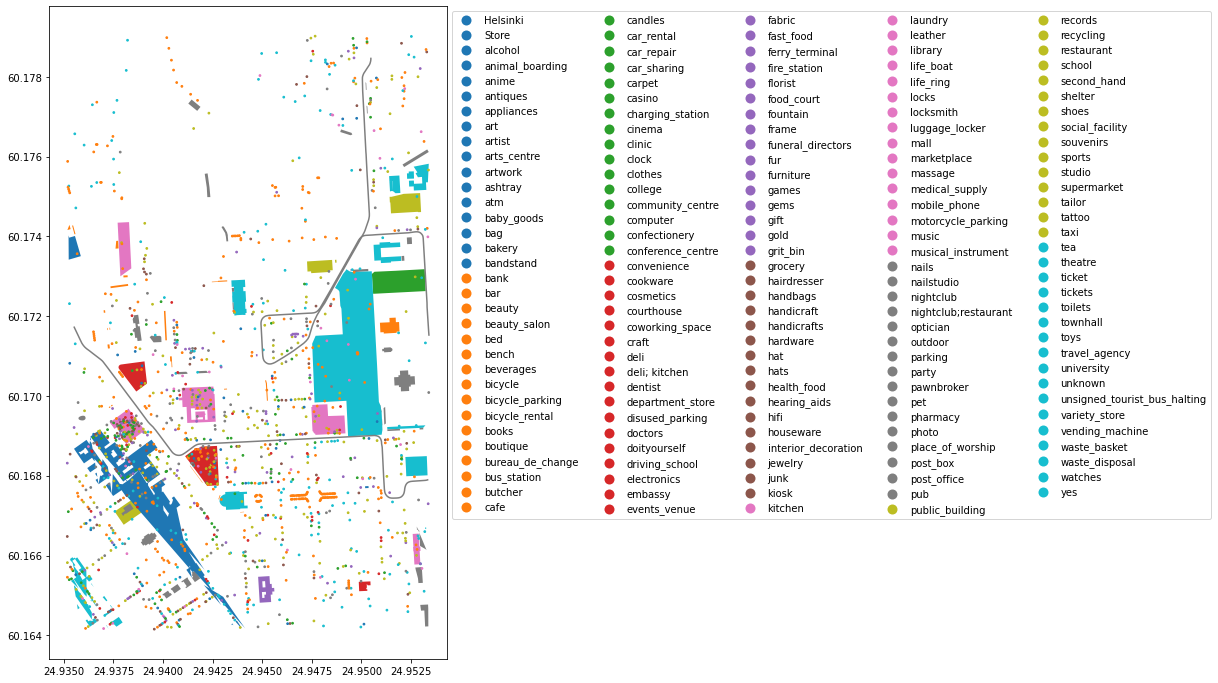

In [72]:
# Read POIs such as amenities and shops
# =====================================

# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

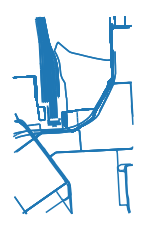

In [73]:
# Test reading all transit related data (bus, trains, trams, metro etc.)
# Exclude nodes (not keeping stops, etc.)
routes = ["bus", "ferry", "railway", "subway", "train", "tram", "trolleybus"]
rails = ["tramway", "light_rail", "rail", "subway", "tram"]
bus = ['yes']
transit = osm.get_data_by_custom_criteria(custom_filter={
                                        'route': routes,
                                        'railway': rails,
                                        'bus': bus,
                                        'public_transport': True},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=False, 
                                        keep_ways=True, 
                                        keep_relations=True)
ax = transit.plot()
ax.axis("off");